# 1. <a id='toc1_'></a>Predictions using [Darts](https://unit8co.github.io/darts/index.html) library [&#8593;](#toc0_)

In this notebook, the [Darts](https://unit8co.github.io/darts/index.html) library is used to make predictions for the ship's navigation. The library is a Python library for easy manipulation and forecasting of time series data. It contains a variety of models, including ARIMA, Exponential Smoothing, and Facebook Prophet.

The usage of Dart came after many trials to make the Pykalman and Pyfilter libraries work. See [this notebook](./predict_ship_navigation.ipynb) for more details.

**Table of contents**<a id='toc0_'></a>    
1. [Predictions using Darts library](#toc1_)    
1.1. [Dependecies](#toc1_1_)    
1.2. [Toy dataset](#toc1_2_)    
1.2.1. [Air Passengers dataset](#toc1_2_1_)    
1.2.2. [Ship navigation dataset](#toc1_2_2_)    
1.3. [Kalman Filter Forecaster](#toc1_3_)    
1.3.1. [Air Passengers](#toc1_3_1_)    
1.3.2. [Ship navigation](#toc1_3_2_)    
1.4. [AutoARIMA](#toc1_4_)    
1.4.1. [Air Passengers](#toc1_4_1_)    
1.4.2. [Ship Navigation](#toc1_4_2_)    
1.5. [Exponential Smoothing](#toc1_5_)    
1.6. [StatsForecastAutoCES](#toc1_6_)    
1.7. [StatsForecastAutoTheta](#toc1_7_)    
1.8. [Theta Method](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

## 1.1. <a id='toc1_1_'></a>[Dependecies](#toc0_)

In [2]:
from typing import List, Tuple, Dict, Any, Callable, Union
#
import numpy as np
import pandas as pd
import datetime
#
from geopy.distance import geodesic
#
from darts import TimeSeries
from darts.models import KalmanForecaster
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries as tg  # For toy time series
# Toy datasets
from darts.datasets import AirPassengersDataset
#
import matplotlib.pyplot as plt
#> TODO: Replace with another visualisation library capable for maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
cmap = cm.coolwarm


## 1.2. <a id='toc1_2_'></a>[Toy dataset](#toc0_)

### 1.2.1. <a id='toc1_2_1_'></a>[Air Passengers dataset](#toc0_)

In [3]:
air_sr = AirPassengersDataset().load()

type(air_sr)

darts.timeseries.TimeSeries

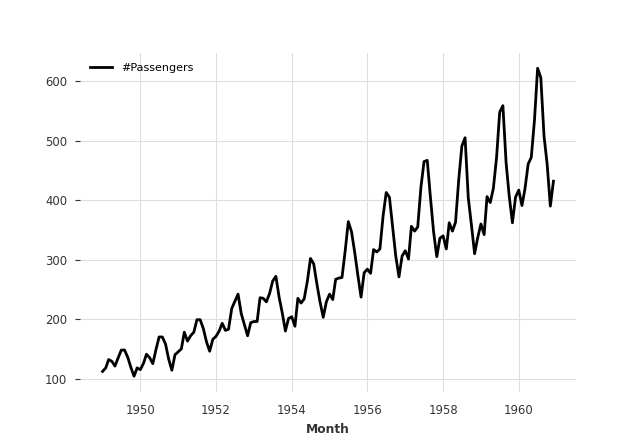

In [4]:
fig, ax = plt.subplots()
ax = air_sr.plot()

### 1.2.2. <a id='toc1_2_2_'></a>[Ship navigation dataset](#toc0_)

In [5]:
# Generate example data
def generate_example_data(start_pos, num_points_straight, num_points_curve):
    lat, lon = start_pos
    SOG = []
    COG = []
    positions = [(lat, lon)]
    
    # Straight line navigation
    for i in range(num_points_straight):
        SOG.append(10 + np.random.randn() * 0.5)  # Speed in knots
        COG.append(90)  # Course in degrees (east)
        distance = SOG[-1] * 1.852 / 3600  # Convert knots to km
        new_pos = geodesic(kilometers=distance).destination(positions[-1], COG[-1])
        positions.append((new_pos.latitude, new_pos.longitude))
    
    # Curved maneuver navigation
    for i in range(num_points_curve):
        SOG.append(10 + np.random.randn() * 0.3)  # Speed in knots
        COG.append(90 + 20*i)  # Gradually changing course
        distance = SOG[-1] * 1.852 / 3600  # Convert knots to km
        new_pos = geodesic(kilometers=distance).destination(positions[-1], COG[-1])
        positions.append((new_pos.latitude, new_pos.longitude))
        
    # Curved maneuver navigation
    for i in range(num_points_curve):
        SOG.append(10 + np.random.randn() * 0.6)  # Speed in knots
        COG.append(-90 - 10*i)  # Gradually changing course
        distance = SOG[-1] * 1.852 / 3600  # Convert knots to km
        new_pos = geodesic(kilometers=distance).destination(positions[-1], COG[-1])
        positions.append((new_pos.latitude, new_pos.longitude))
    
    return SOG, COG, positions

In [6]:
# Plot the navigation on a map
def plot_navigation(positions, speeds=None, prediction=False, fig=None, ax=None):
    lats, lons = zip(*positions)
    
    ## Plot using Cartopy >>
    if fig is None or ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    # ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    if not prediction:  # Plot the actual navigation
        ax.scatter(lons, lats, color='blue', marker='o', alpha=0.7, transform=ccrs.PlateCarree(), zorder=1)
        # for i, (lat, lon) in enumerate(positions):
        #     ax.text(lon + 0.1, lat + 0.1, f"Point {i+1}", color='blue', transform=ccrs.PlateCarree(), fontsize=10, zorder=3)
        
        # Color map based on speeds
        if speeds is None:
            ax.plot(lons, lats, color='cyan', linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
        else:
            for i in range(len(positions)-1):
                ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], color=cmap(speeds[i]/np.max(speeds)), linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
                
        ax.set_title('Ship Navigation in Kiel Fjord', fontsize=15)
        ax.set_extent([np.min(lons)-1E-4, np.max(lons)+1E-4, np.min(lats)-1E-4, np.max(lats)+1E-4], crs=ccrs.PlateCarree())  # Adjust based on your data extent
        
    if prediction:  # Plot the predicted navigation
        ax.scatter(lons, lats, color='red', marker='x', alpha=0.7, transform=ccrs.PlateCarree(), zorder=1)
        # for i, (lat, lon) in enumerate(positions):
        #     ax.text(lon + 0.1, lat + 0.1, f"Point {i+1}", color='blue', transform=ccrs.PlateCarree(), fontsize=10, zorder=3)
        
        # Color map based on speeds
        if speeds is None:
            ax.plot(lons, lats, color='green', linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
        else:
            for i in range(len(positions)-1):
                ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], '--' , color=cmap(speeds[i]/np.max(speeds)), linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
                
        ax.set_title('Ship Navigation in Kiel Fjord', fontsize=15)
        ax.set_extent([np.min(lons)-1E-4, np.max(lons)+1E-4, np.min(lats)-1E-4, np.max(lats)+1E-4], crs=ccrs.PlateCarree())  # Adjust based on your data extent
    
        
    # Create a colorbar for speeds
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(speeds), vmax=np.max(speeds)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='horizontal', label='Speed (knots)')
    
    return fig, ax

(<Figure size 640x440 with 2 Axes>,
 <GeoAxes: title={'center': 'Ship Navigation in Kiel Fjord'}>)

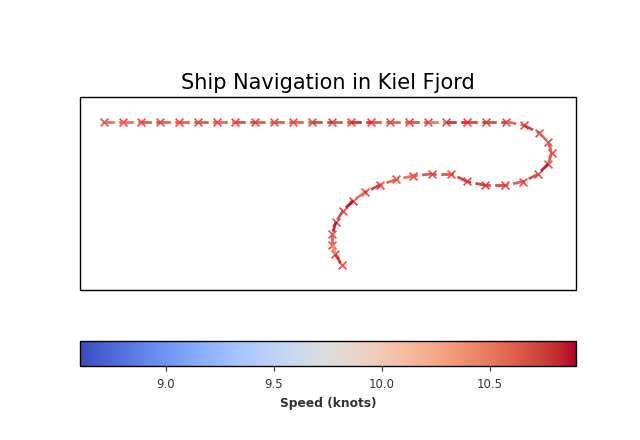

In [7]:
# Example usage
start_pos = (54.321, 10.134)  # Example starting position in Kiel Fjord
num_points_straight = 20
num_points_curve = 12

SOG, COG, positions = generate_example_data(start_pos, num_points_straight, num_points_curve)

plot_navigation(positions, SOG, prediction=True)

In [8]:
## Leave the last 7 points for test >>
num_predictions = 5
start_train_pos = positions[0]
start_predict_pos = positions[-num_predictions]

positions_train, SOG_train, COG_train = positions[:-num_predictions], SOG[:-num_predictions], COG[:-num_predictions]
positions_test, SOG_test, COG_test = positions[-num_predictions::], SOG[-num_predictions::], COG[-num_predictions::]

In [9]:
## Convert the lists into dart.TimeSeries objects though middle conversion using pandas DF >>

# Convert training data to DataFrame
lat, lon = zip(*positions_train)
lat, lon = list(lat), list(lon)

train_df = pd.DataFrame({'lat': lat[:-1], 
                         'lon': lon[:-1], 
                         'sog': SOG_train,
                         'cog': COG_train})

# Convert testing data to DataFrame
lat, lon = zip(*positions_test)
lat, lon = list(lat), list(lon)

test_df = pd.DataFrame({'lat': lat, 
                         'lon': lon, 
                         'sog': SOG_test,
                         'cog': COG_test})

test_df.head()


,lat,lon,sog,cog
0,54.320590,10.134947,10.026342,-160
1,54.320541,10.134932,10.769379,-170
2,54.320496,10.134932,9.711218,-180
3,54.320457,10.134944,8.603929,-190
4,54.320412,10.134972,10.472338,-200


In [10]:
sog_ts = TimeSeries.from_values(np.array(SOG_train))
cog_ts = TimeSeries.from_values(np.array(COG_train))

In [11]:
# Convert DataFrames to TimeSeries
train_ts = TimeSeries.from_dataframe(train_df, time_col=None, value_cols=['lat', 'lon', 'sog', 'cog'])
test_ts = TimeSeries.from_dataframe(test_df, time_col=None, value_cols=['lat', 'lon', 'sog', 'cog'])


# Print the TimeSeries
print("Training TimeSeries:")
print(train_ts.head(2))
print("\nTest TimeSeries:")
print(test_ts.head(2))

Training TimeSeries:
<TimeSeries (DataArray) (time: 2, component: 4, sample: 1)> Size: 64B
array([[[54.321     ],
        [10.134     ],
        [ 9.43780573],
        [90.        ]],

       [[54.321     ],
        [10.13407462],
        [ 9.42517314],
        [90.        ]]])
Coordinates:
  * time       (time) int64 16B 0 1
  * component  (component) object 32B 'lat' 'lon' 'sog' 'cog'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Test TimeSeries:
<TimeSeries (DataArray) (time: 2, component: 4, sample: 1)> Size: 64B
array([[[  54.32059029],
        [  10.13494655],
        [  10.0263419 ],
        [-160.        ]],

       [[  54.32054127],
        [  10.13493176],
        [  10.76937933],
        [-170.        ]]])
Coordinates:
  * time       (time) int64 16B 0 1
  * component  (component) object 32B 'lat' 'lon' 'sog' 'cog'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:    

## 1.3. <a id='toc1_3_'></a>[Kalman Filter Forecaster](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.kalman_forecaster.html) [&#8593;](#toc0_)

### 1.3.1. <a id='toc1_3_1_'></a>[Air Passengers](#toc0_)

<class 'darts.timeseries.TimeSeries'>


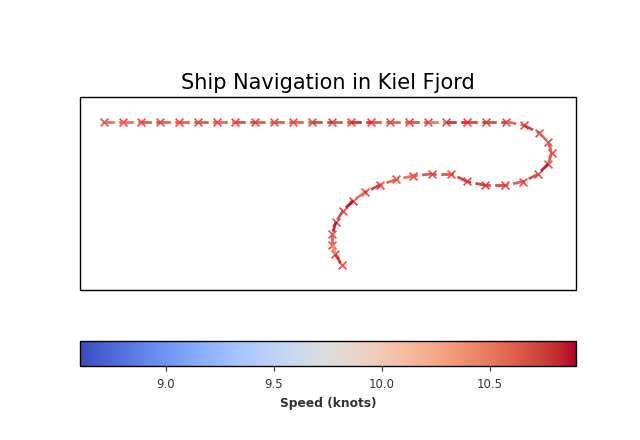

In [12]:
## Fit the model
model = KalmanForecaster(dim_x=12)  # dim_x: Size of the Kalman filter state vector. Default is 1.
model.fit(series=air_sr)

## Predict
pred = model.predict(n=12)
print(type(pred))
pred.plot(label='Predicted', ax=ax)
plt.show()

### 1.3.2. <a id='toc1_3_2_'></a>[Ship navigation](#toc0_)

In [13]:
n_timesteps = cog_ts.n_timesteps
width = cog_ts.width

print(f"Number of time steps: {n_timesteps}")
print(f"Number of components: {width}")

Number of time steps: 39
Number of components: 1


In [14]:
## Fit the model to only sog
buffer_size = 12
assert(buffer_size/cog_ts.n_timesteps < (1/3))  # The buffer size should be at least 1/3 of the time series length. This is an experimental value.

model = KalmanForecaster(dim_x=buffer_size)  # dim_x: Size of the Kalman filter state vector. Default is 1.
model.fit(series=cog_ts)  # (series=sog_ts)

## Predict
pred = model.predict(n=num_predictions)  # Predict only sog and cog on the next num_predictions

pred.values()

array([[-217.07356037],
       [-250.30144108],
       [-281.2271191 ],
       [-309.31550516],
       [-334.05140921]])

In [15]:
COG_test[:num_predictions]

[-160, -170, -180, -190, -200]

In [16]:
## Fit the model
buffer_size = 10
selected_components = ['sog', 'cog']  # Select the components to use for prediction
model = KalmanForecaster(dim_x=buffer_size)  # dim_x: Size of the Kalman filter state vector. Default is 1.
model.fit(series=train_ts)

## Predict
pred = model.predict(n=num_predictions)  # Predict only sog and cog on the next num_predictions
pred.values()

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

> ``BUG``: For taining with multiple components, it is not working, and returns only zeros.

## 1.4. <a id='toc1_4_'></a>[AutoARIMA](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.auto_arima.html) [&#8593;](#toc0_)

In [17]:
from darts.models import AutoARIMA

### 1.4.1. <a id='toc1_4_1_'></a>[Air Passengers](#toc0_)

In [18]:
model_sog = AutoARIMA()
model.fit(series=air_sr)
pred_sog = model.predict(n=num_predictions)
pred_sog.values()

array([[478.55210466],
       [492.96178331],
       [499.4484772 ],
       [501.87488663],
       [567.64575913]])

### 1.4.2. <a id='toc1_4_2_'></a>[Ship Navigation](#toc0_)

In [19]:
model = AutoARIMA()
model.fit(series=cog_ts)
pred = model.predict(n=num_predictions)
pred.values()

array([[-133.53542137],
       [-118.87805841],
       [-105.82954414],
       [ -94.21328514],
       [ -83.87207153]])

In [20]:
COG_test

[-160, -170, -180, -190, -200]

## 1.5. <a id='toc1_5_'></a>[Exponential Smoothing](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html) [&#8593;](#toc0_)

In [33]:
from darts.models import ExponentialSmoothing

Predicted values: [[-142.3818744 ]
 [-138.71333369]
 [-135.7870906 ]
 [-129.08295934]
 [-119.17050046]] 
 Actual values: [-160, -170, -180, -190, -200]


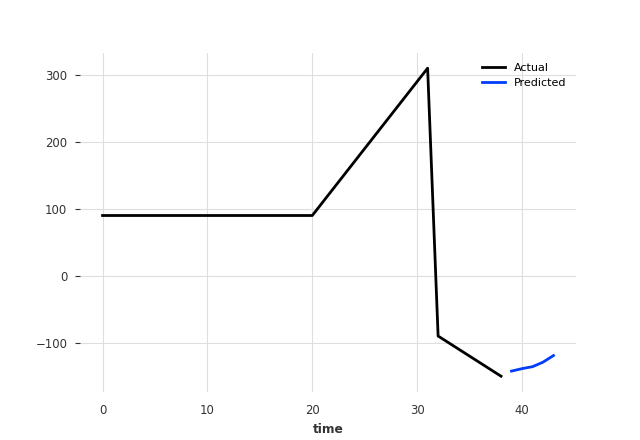

In [34]:
model = ExponentialSmoothing()
model.fit(cog_ts)

# Predict the next 5 steps
pred = model.predict(n=num_predictions)

# Print
print(f"Predicted values: {pred.values()} \n Actual values: {COG_test}")

# Plot the results
fig, ax = plt.subplots()
cog_ts.plot(label='Actual', ax=ax)
pred.plot(label='Predicted', ax=ax)
plt.legend()
plt.show()

## 1.6. <a id='toc1_6_'></a>[StatsForecastAutoCES](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.statsmodels_forecaster.html) [&#8593;](#toc0_)

In [38]:
from darts.models import StatsForecastAutoCES

Predicted values: [[-154.49263   ]
 [-140.15765381]
 [-146.15107727]
 [-136.38975525]
 [-139.01985168]] 
 Actual values: [-160, -170, -180, -190, -200]


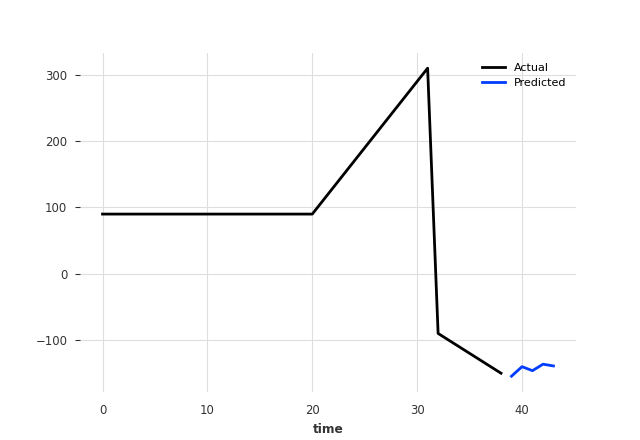

In [39]:
model = StatsForecastAutoCES()
model.fit(cog_ts)

# Predict the next 5 steps
pred = model.predict(n=num_predictions)

# Print
print(f"Predicted values: {pred.values()} \n Actual values: {COG_test}")

# Plot the results
fig, ax = plt.subplots()
cog_ts.plot(label='Actual', ax=ax)
pred.plot(label='Predicted', ax=ax)
plt.legend()
plt.show()

## 1.7. <a id='toc1_7_'></a>[StatsForecastAutoTheta](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.statsmodels_forecaster.html) [&#8593;](#toc0_)

In [40]:
from darts.models import StatsForecastAutoTheta

Predicted values: [[-152.42500305]
 [-154.92576599]
 [-157.42652893]
 [-159.92729187]
 [-162.42805481]] 
 Actual values: [-160, -170, -180, -190, -200]


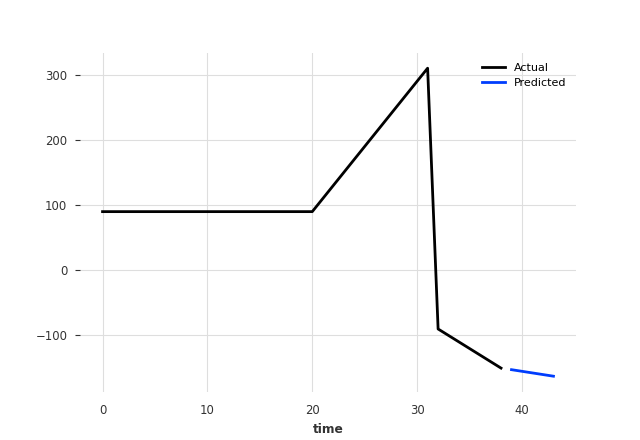

In [41]:
model = StatsForecastAutoTheta()
model.fit(cog_ts)

# Predict the next 5 steps
pred = model.predict(n=num_predictions)

# Print
print(f"Predicted values: {pred.values()} \n Actual values: {COG_test}")

# Plot the results
fig, ax = plt.subplots()
cog_ts.plot(label='Actual', ax=ax)
pred.plot(label='Predicted', ax=ax)
plt.legend()
plt.show()

## 1.8. <a id='toc1_8_'></a>[Theta Method](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.theta.html) [&#8593;](#toc0_)

In [45]:
from darts.models import FourTheta

Time series has negative values. Fallback to additive and linear model


Predicted values: [[-151.24939729]
 [-152.50040943]
 [-153.75142158]
 [-155.00243372]
 [-156.25344587]] 
 Actual values: [-160, -170, -180, -190, -200]


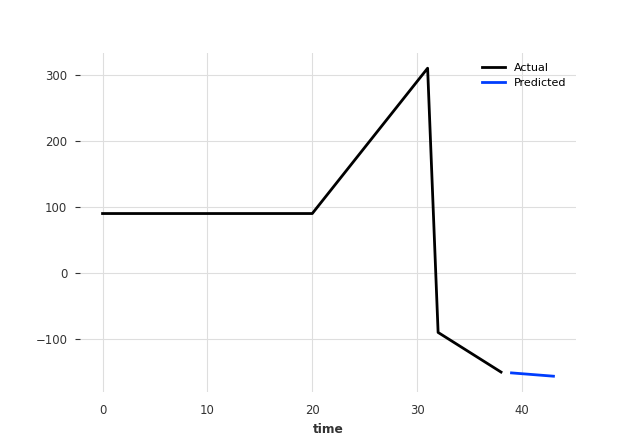

In [46]:
model = FourTheta(theta=2)
model.fit(cog_ts)

# Predict the next 5 steps
pred = model.predict(n=num_predictions)

# Print
print(f"Predicted values: {pred.values()} \n Actual values: {COG_test}")

# Plot the results
fig, ax = plt.subplots()
cog_ts.plot(label='Actual', ax=ax)
pred.plot(label='Predicted', ax=ax)
plt.legend()
plt.show()